## Instructions {-}

1. You may talk to a friend, discuss the questions and potential directions for solving them. However, you need to write your own solutions and code separately, and not as a group activity. 

2. Write your code in the **Code cells** and your answers in the **Markdown cells** of the Jupyter notebook. Ensure that the solution is written neatly enough to for the graders to understand and follow.

3. Use [Quarto](https://quarto.org/docs/output-formats/html-basics.html) to render the **.ipynb** file as HTML. You will need to open the command prompt, navigate to the directory containing the file, and use the command: `quarto render filename.ipynb --to html`. Submit the HTML file.

4. There is a **bonus** question worth 11 points.

5. **Five points are properly formatting the assignment**. The breakdown is as follows:
    - Must be an HTML file rendered using Quarto **(1 point)**. *If you have a Quarto issue, you must mention the issue & quote the error you get when rendering using Quarto in the comments section of Canvas, and submit the ipynb file.* 
    - No name can be written on the assignment, nor can there be any indicator of the student’s identity—e.g. printouts of the working directory should not be included in the final submission.  **(1 point)**
    - There aren’t excessively long outputs of extraneous information (e.g. no printouts of entire data frames without good reason, there aren’t long printouts of which iteration a loop is on, there aren’t long sections of commented-out code, etc.) **(1 point)**
    - Final answers to each question are written in the Markdown cells. **(1 point)**
    - There is no piece of unnecessary / redundant code, and no unnecessary / redundant text. **(1 point)**

6.  The maximum possible score in the assigment is 99 + 11 + 5 = 115 out of 100.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.model_selection import GridSearchCV

## 1) Modeling the Radii of Exoplanets (40 points)

For this question, we are interested in predicting the radius of exoplanets (planets outside the Solar System) in kilometers. To achieve this goal, we will use NASA's Composite Planetary Systems dataset and different regression models. (See https://exoplanetarchive.ipac.caltech.edu for more context.)

Read all three CompositePlanetarySystems datasets - you should have one training and two test datasets. Each row is an exoplanet. `pl_rade` column represents the radius of each exoplanet as a proportion of Earth’s radius, which is approximately 6,378 km.

In [2]:
train_exo = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/train_CompositePlanetarySystems.csv")
test1_exo = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/test1_CompositePlanetarySystems.csv")
test2_exo = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/test2_CompositePlanetarySystems.csv")

### a)

Develop a linear regression model (no non-linear terms) to predict `pl_rade` using all the raw variables in the data except `pl_name`, `disc_facility` and `disc_locale`. You can use either `statsmodels` or `sklearn`. **(2 points)**

In [3]:
predictors = train_exo.columns.difference(['pl_name', 'disc_facility', 'disc_locale', "pl_rade"])

x_train = train_exo[predictors]
y_train = train_exo["pl_rade"]

model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

### b)

Find the `RMSE` of the model using both test sets **separately**. (You need to print two `RMSE` values.) Note that the library you used should not make a difference here! **(2 points)**

Print the training `RMSE` as well for reference. **(1 point)**

In [4]:
y_pred_train = model.predict(x_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(train_rmse)

2.7536937477346655


In [5]:
# test1 RMSE
x_test1 = test1_exo[predictors]
y_test1 = test1_exo["pl_rade"]

y_pred_test1 = model.predict(x_test1)
test1_rmse = np.sqrt(mean_squared_error(y_test1, y_pred_test1))
print(test1_rmse)

127.3659549635975


In [6]:
# test2 RMSE
x_test2 = test2_exo[predictors]
y_test2 = test2_exo["pl_rade"]

y_pred_test2 = model.predict(x_test2)
test2_rmse = np.sqrt(mean_squared_error(y_test2, y_pred_test2))
print(test2_rmse)

202.66277572548105


### c)

Compare the training and test `RMSEs`. **(1 point)** What is the issue with this model? **(1 point)**

The train RMSE is far lower than both the test RMSEs, which is a sign of overfitting. This means the coefficient values are likely too high and are memorizing the training data.

### d)

Train a **Ridge regression model** to predict `pl_rade` using the same set of variables as above. Optimize the regularization strength (`alpha`) using **`RidgeCV`** with **5-fold cross-validation**, ensuring that the data is **shuffled** before splitting (`random_state=42`). Use **`neg_root_mean_squared_error`** as the scoring metric.  

**Note:**

- Scaling is essential for regularization to ensure fair weighting of features.  
- Use the following range of **alpha** for hyperparamter tuning: `alphas = np.logspace(2,0.5,200)`

In [7]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test1_scaled = scaler.transform(x_test1)
x_test2_scaled = scaler.transform(x_test2)

alphas = np.logspace(2, 0.5, 200)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_cv = RidgeCV(alphas=alphas, cv=kf, scoring='neg_root_mean_squared_error')
ridge_cv.fit(x_train_scaled, y_train)

optimal_alpha = ridge_cv.alpha_
print(optimal_alpha)


3.1622776601683795


### e)

Using the optimized model, print the `RMSEs` for the training set and both test sets. **(4 points)**

In [8]:
y_train_pred = ridge_cv.predict(x_train_scaled)
y_test1_pred = ridge_cv.predict(x_test1_scaled)
y_test2_pred = ridge_cv.predict(x_test2_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test1_rmse = np.sqrt(mean_squared_error(y_test1, y_test1_pred))
test2_rmse = np.sqrt(mean_squared_error(y_test2, y_test2_pred))

print(f"Train RMSE: {train_rmse:.6f}")
print(f"Test 1 RMSE: {test1_rmse:.6f}")
print(f"Test 2 RMSE: {test2_rmse:.6f}")

Train RMSE: 2.781436
Test 1 RMSE: 3.219463
Test 2 RMSE: 2.993658


### f)

How did the training and test performance change? Explain why the Ridge regression changed the training and test results. **(3 points)**

All three RMSE values shrunk dramatically due to the feature scaling. However, test1 RMSE used to be lower than test2's, but it has now become higher. The train RMSE is still lower than both the test RMSEs, which is a sign of overfitting.

### g)

Find the predictor whose coefficient is shrunk by far the most by Ridge regularization. **(3 points)**

**Hint:** `.coef_` and `.columns` attributes should be helpful.

In [9]:
coef_dict = dict(zip(predictors,  np.abs(model.coef_ - ridge_cv.coef_)))

print(max(coef_dict, key=coef_dict.get))


ima_flag


### h)

Why did the coefficient of the predictor identified in the previous question shrunk the most? Justify your answer for credit. **(2 points)**

**Hint:** Correlation vector/matrix

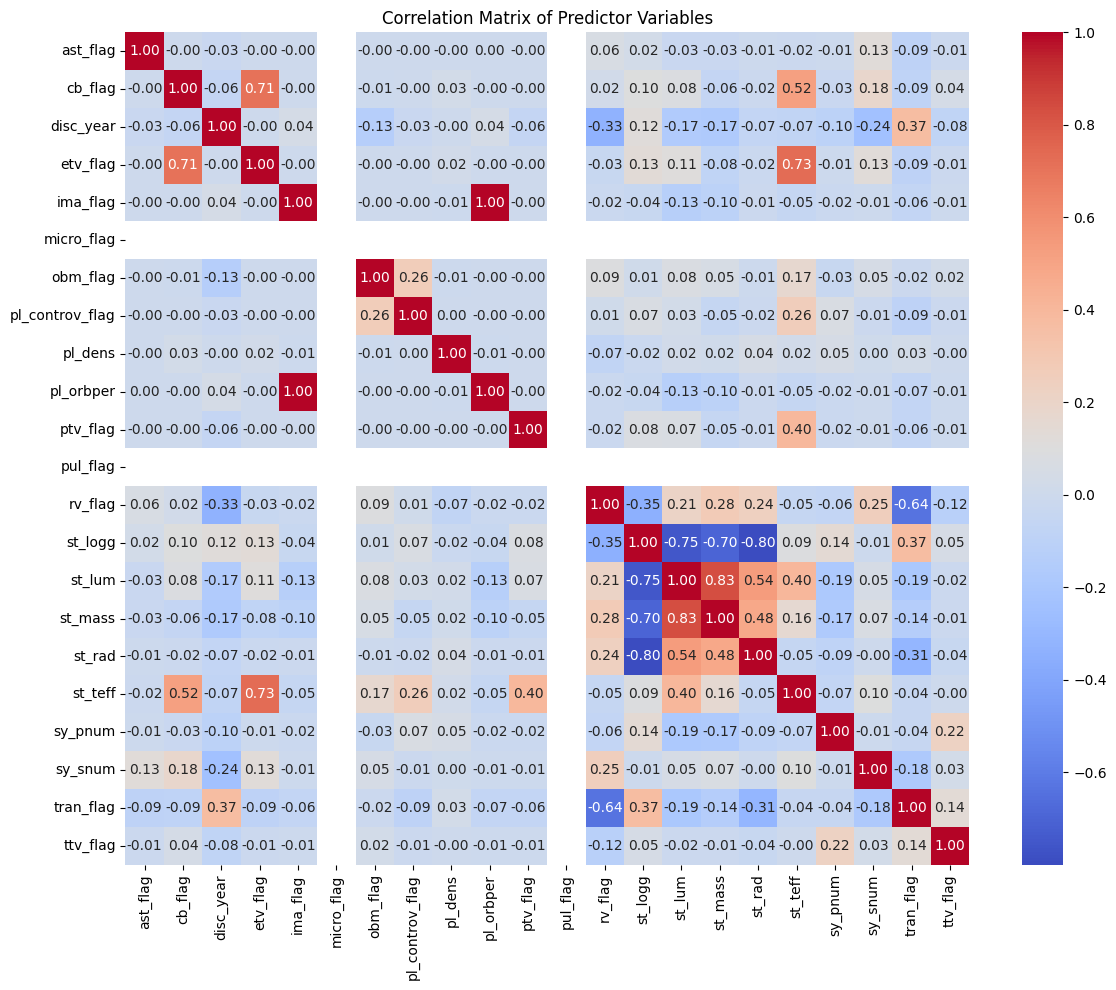

In [10]:
import seaborn as sns 

plt.figure(figsize=(12, 10))
sns.heatmap(x_train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Predictor Variables')
plt.tight_layout()
plt.show()

The coefficient for ima_flag was likely shrunk the most because it has perfect multicollinearity with pl_orbper and ridge regression shrinks coefficients of highly correlated predictors towards 0.

### i)

Visualize how the coefficients change with the change in the hyperparameter value:

- Create a line plot of coefficient values vs. the hyperparameter value.
- Color code each predictor's coefficient values.
- Use log scale where necessary.
- Use an alphas vector of `np.logspace(7,0,200)` for better visualization

**(5 points)**

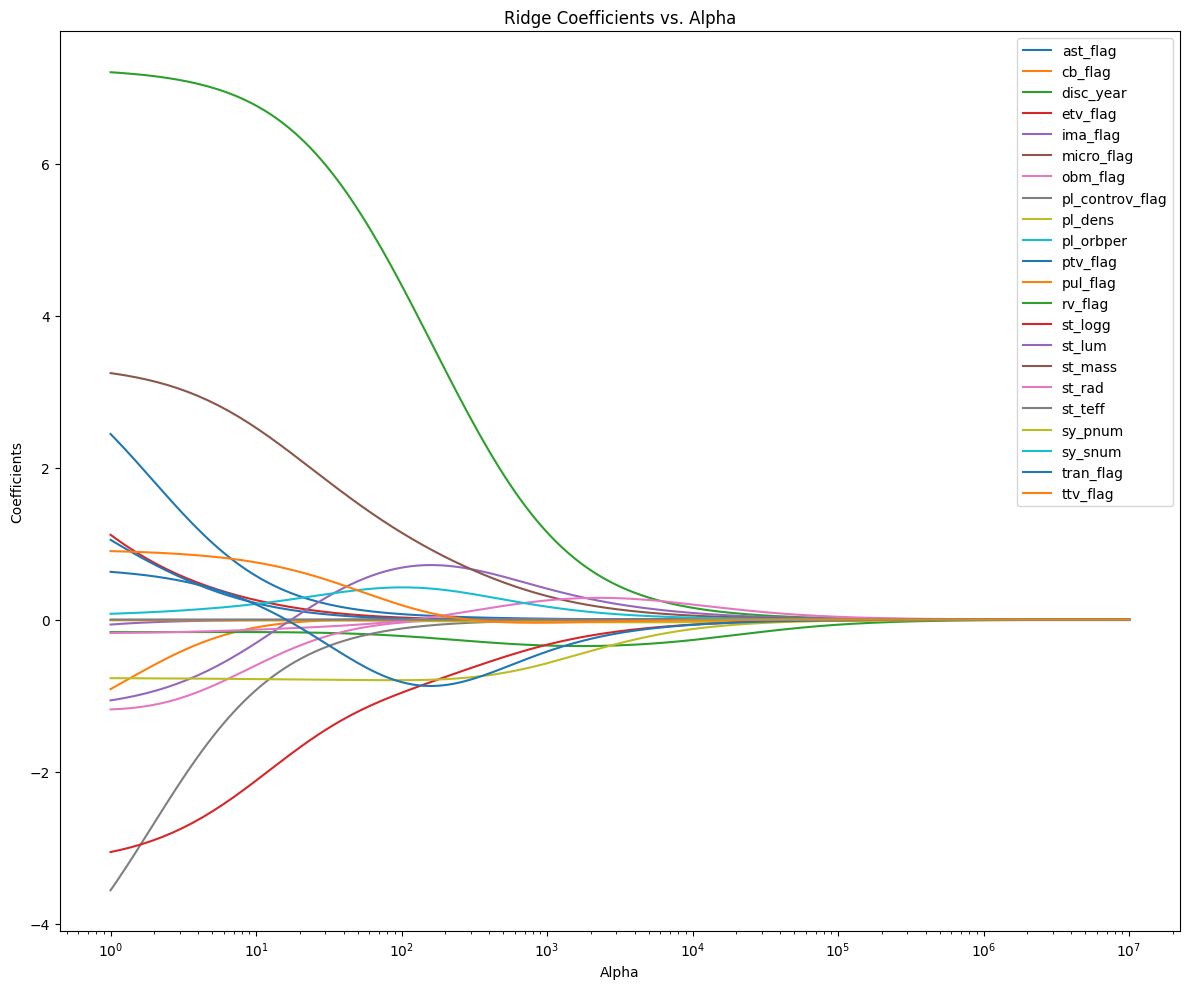

In [11]:
def plot_ridge_coef(x_train):
    alphas = np.logspace(7, 0, 200)
    coefs = []

    for a in alphas:
        ridge = Ridge(alpha=a)
        ridge.fit(x_train, y_train)
        coefs.append(ridge.coef_)

    plt.figure(figsize=(12, 10))
    plt.plot(alphas, coefs)
    plt.xlabel('Alpha')
    plt.ylabel('Coefficients')
    plt.title('Ridge Coefficients vs. Alpha')
    plt.legend(predictors)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

plot_ridge_coef(x_train)

### **j)**

Replace the Ridge regression with Lasso regression.

- Find the optimal hyperparameter using `LassoCV`** **(2 points)**.
    - You need a different hyperparameter array - use: `np.logspace(0,-2.5,200)`
    - Using the same splitting strategy as Ridge regression
    - Note: The `Lasso` object does not have a `scoring` hyperparameter.
- Using the optimized Lasso model, print the `RMSEs` for the training set and both test sets. **(2 points)**
- Visualize how the Lasso coefficients change with alpha. **(2 points)**
    - You may use the  range of alpha values as `np.logspace(7,-2.5,200)` for better visualization.

In [12]:
from sklearn.linear_model import LassoCV

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test1_scaled = scaler.transform(x_test1)
x_test2_scaled = scaler.transform(x_test2)

alphas2 = np.logspace(0, -2.5, 200)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lasso = LassoCV(alphas=alphas2, cv=kf, random_state=42)
lasso.fit(x_train_scaled, y_train)

optimal_alpha = lasso.alpha_
print(optimal_alpha)

y_train_pred = lasso.predict(x_train_scaled)
y_test1_pred = lasso.predict(x_test1_scaled)
y_test2_pred = lasso.predict(x_test2_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test1_rmse = np.sqrt(mean_squared_error(y_test1, y_test1_pred))
test2_rmse = np.sqrt(mean_squared_error(y_test2, y_test2_pred))

print(f"Train RMSE: {train_rmse:.6f}")
print(f"Test 1 RMSE: {test1_rmse:.6f}")
print(f"Test 2 RMSE: {test2_rmse:.6f}")

0.0031622776601683794
Train RMSE: 2.781435
Test 1 RMSE: 3.218050
Test 2 RMSE: 2.996144


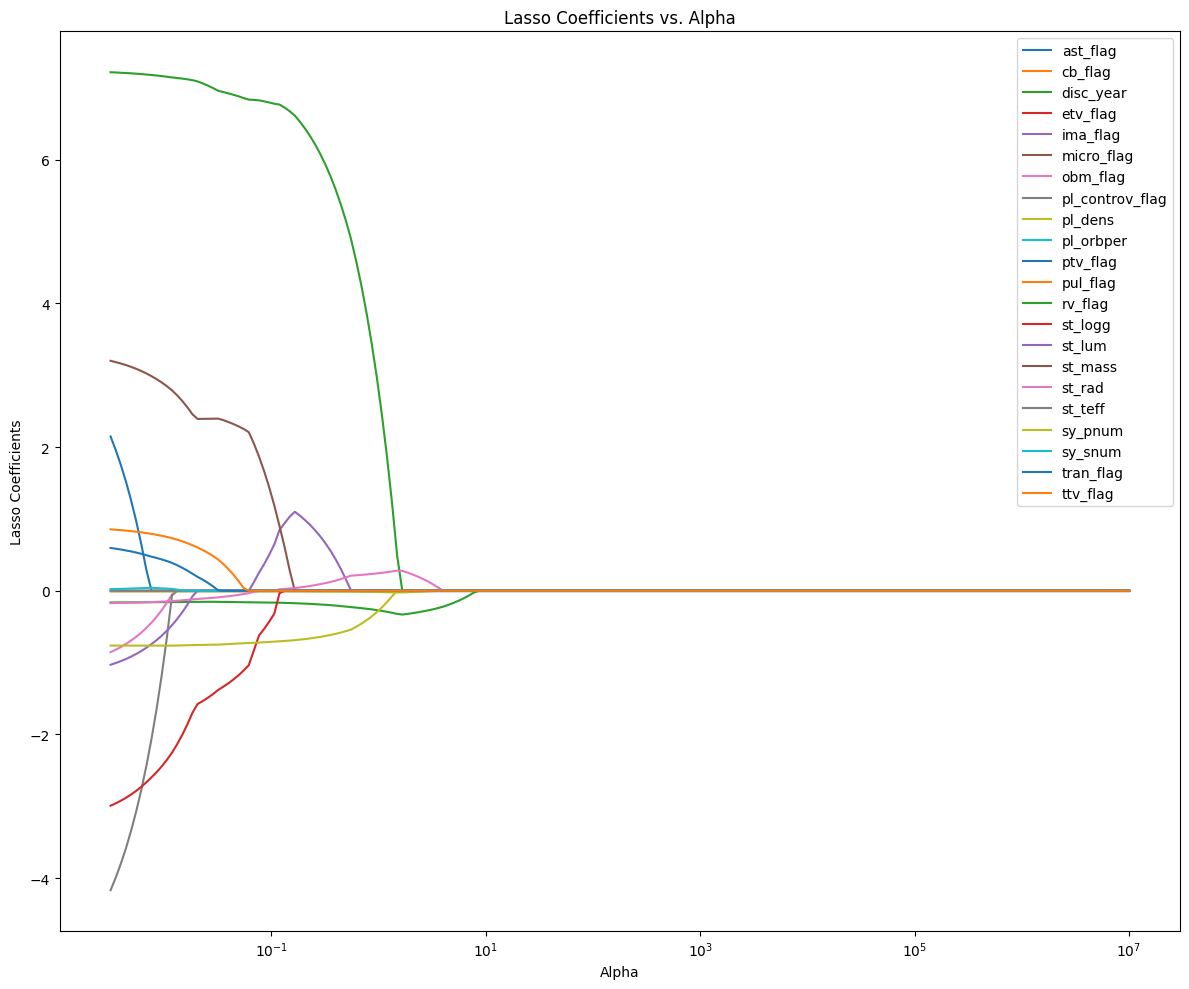

In [13]:
def plot_lasso_coef(x_train):
    alphas_vis = np.logspace(7,-2.5, 200)
    coefs = []

    for a in alphas_vis:
        lasso = LassoCV(alphas =[a])
        lasso.fit(x_train, y_train)
        coefs.append(lasso.coef_)

    plt.figure(figsize=(12, 10))
    plt.plot(alphas_vis, coefs)
    plt.xlabel('Alpha')
    plt.ylabel('Lasso Coefficients')
    plt.title('Lasso Coefficients vs. Alpha')
    plt.legend(predictors)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

plot_lasso_coef(x_train)  

### **k)** 

Using the two figures created in parts i and j, explain how the Ridge and Lasso models behave differently as the hyperparameter value changes. **(2 points)** What does that difference mean for the usage of the Lasso model? **(1 point)**

The lasso model drives coefficients to 0 as alpha increases, while ridge model decreases coefficients more gradually towards 0, while none reach 0. Because Lasso drives some coefficients to 0, the model could be simpler than Ridge.

### **l)** 

Find the predictors that are eliminated by Lasso regularization. **(2 points)**

In [14]:
lasso_coefs = dict(zip(predictors, lasso.coef_))

for key, value in lasso_coefs.items():
    if value == 0:
        print(key)

ima_flag
micro_flag
pul_flag


## 2) Enhancing House Price Prediction with Higher-Order Terms and Cross-Validation (29 points)

In this question, we are interested in improving the prediction performance for house prices using five predictors. 

### a) 

Read the house feature and price files and create the training and test datasets. The response is log-price and the five predictors are the rest of the variables, except house_id. **(2 points)**

In [21]:
train_feature = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/house_feature_train.csv")
test_feature = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/house_feature_test.csv")
train_price = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/house_price_train.csv")
test_price = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/house_price_test.csv")

In [22]:
train = pd.merge(train_feature, train_price, on="house_id")
test = pd.merge(test_feature, test_price, on="house_id")

### b)

Previously, we observed that a linear model using raw predictors fails to capture the complexity of the problem, resulting in **underfitting**. Our goal is to examine how training and test performance evolve as model complexity increases. 

Task Breakdown:

1. **Generate Higher-Order Features**  

   - Use `PolynomialFeatures` from `sklearn` to create higher-order versions of the predictors (including both transformations and interactions) for both the training and test datasets. **(3 points)**  

2. **Train a Ridge Regression Model**  
   - Use all predictors (original and transformed) to train a **Ridge regression model** with `alpha = 0.000001`. **(2 points)**  

3. **Compute RMSE Scores**  
   - Store the **RMSE** for both the training and test sets. **(2 points)**  

4. **Repeat for Different Polynomial Orders**  
   - Perform this process for polynomial orders ranging from **1 to 6**. **(2 points)**  

5. **Visualize the Performance**  
   - Plot the **training and test RMSE values** as a function of polynomial order. Ensure:  
     - The two curves have distinct colors. **(1 points)**  
     - A legend is included for clarity. **(1 points)**  

**Notes:**  

- **Exclude the bias term** that `PolynomialFeatures` adds by default.  
- **Feature scaling is required** for regularization. **(2 points)**  
- **Minimal regularization is necessary** to prevent the test RMSE from diverging to infinity at higher polynomial orders, unlike in pure linear regression.


Order: 1, Train RMSE: 0.3722714456802243, Test RMSE: 0.3549192976311997
Order: 2, Train RMSE: 0.31051724008038684, Test RMSE: 0.2918427243287983
Order: 3, Train RMSE: 0.29022985396854445, Test RMSE: 0.2969456168277557
Order: 4, Train RMSE: 0.26017974658758963, Test RMSE: 0.35829278230093015
Order: 5, Train RMSE: 0.24071341940295327, Test RMSE: 0.3753284700723016
Order: 6, Train RMSE: 0.20767093229992095, Test RMSE: 0.7908568628287476


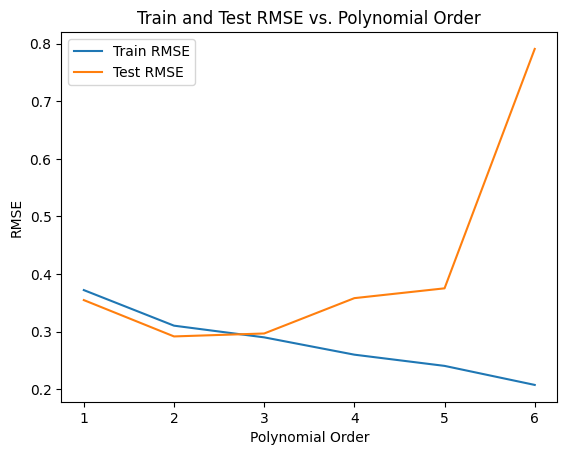

In [23]:
from sklearn.preprocessing import PolynomialFeatures

all_preds = train.columns.difference(['house_id', 'house_price'])

x_train = train[all_preds]
y_train = np.log(train["house_price"])

x_test = test[all_preds]
y_test = np.log(test["house_price"])

train_rmse_vals = []
test_rmse_vals = []

poly_orders = range(1,7)

for order in poly_orders:
    poly = PolynomialFeatures(degree = order, include_bias=False)
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.transform(x_test)

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_poly)
    x_test_scaled = scaler.transform(x_test_poly)

    ridge_model = Ridge(alpha = 0.000001)
    ridge_model.fit(x_train_scaled, y_train)

    y_train_pred = ridge_model.predict(x_train_scaled)
    y_test_pred = ridge_model.predict(x_test_scaled)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_rmse_vals.append(train_rmse)
    test_rmse_vals.append(test_rmse)

    print(f"Order: {order}, Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

# plot poly_orders against train_rmse_vals and test_rmse_vals

plt.plot(poly_orders, train_rmse_vals)
plt.plot(poly_orders, test_rmse_vals)
plt.xlabel('Polynomial Order')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE vs. Polynomial Order')
plt.legend(['Train RMSE', 'Test RMSE'])
plt.show()

### **c)** 

Which order has the best test RMSE? **(1 point)** What is the best test RMSE? **(1 point)** At which order does the overfitting start? **(1 point)**

In [25]:
best_test_rmse = min(test_rmse_vals)
best_test_order = poly_orders[test_rmse_vals.index(best_test_rmse)]

print(f"Best Test RMSE: {best_test_rmse}, Best Test Order: {best_test_order}")

Best Test RMSE: 0.2918427243287983, Best Test Order: 2


Overfitting starts from order 4 and above.

### d)

Repeat part b, only this time use `RidgeCV` to find the best amount of regularization for each order by cross-validation. Use `alphas = np.logspace(2,0.5,200)` and `LOOCV`. Use `neg_root_mean_squared_error` for scoring. Create the same plot as part b. **(4 points)** Describe the obvious difference between the plot in this part and the plot in part b. **(2 points)**

/Users/vaibhavrangan/Downloads/Stat_303-2/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warning

Optimal Alpha: 100.0, Order: 1, Train RMSE: 0.3894914446591027, Test RMSE: 0.3480342755799762


/Users/vaibhavrangan/Downloads/Stat_303-2/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warning

Optimal Alpha: 100.0, Order: 2, Train RMSE: 0.3632963939141258, Test RMSE: 0.33220005617688353


/Users/vaibhavrangan/Downloads/Stat_303-2/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warning

Optimal Alpha: 100.0, Order: 3, Train RMSE: 0.34152912088897236, Test RMSE: 0.315264706766797


/Users/vaibhavrangan/Downloads/Stat_303-2/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warning

Optimal Alpha: 100.0, Order: 4, Train RMSE: 0.3287869028579174, Test RMSE: 0.306265509074944


/Users/vaibhavrangan/Downloads/Stat_303-2/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warning

Optimal Alpha: 100.0, Order: 5, Train RMSE: 0.3220936016014372, Test RMSE: 0.3004329488095997
Optimal Alpha: 100.0, Order: 6, Train RMSE: 0.31566587687427416, Test RMSE: 0.29606610771520214


/Users/vaibhavrangan/Downloads/Stat_303-2/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warning

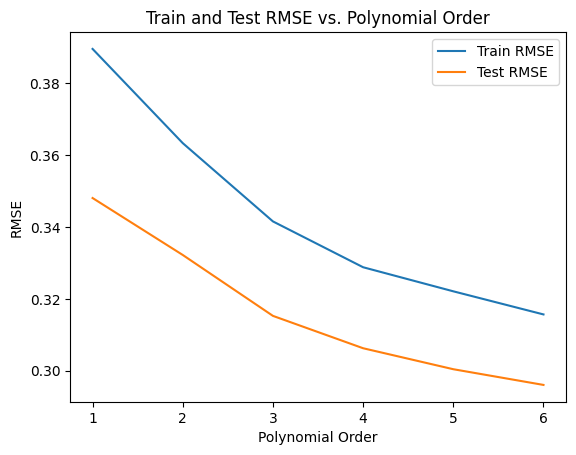

In [26]:
from sklearn.model_selection import LeaveOneOut
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", UndefinedMetricWarning)


train_rmse_cv_vals = []
test_rmse_cv_vals = []
optimal_alphas = []
poly_orders = range(1,7)
loo = LeaveOneOut()

for order in poly_orders:
    poly = PolynomialFeatures(degree = order, include_bias=False)
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.transform(x_test)

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_poly)
    x_test_scaled = scaler.transform(x_test_poly)

    ridge_model = RidgeCV(alphas = np.logspace(2, 0.5, 200), cv=loo)
    ridge_model.fit(x_train_scaled, y_train)

    optimal_alpha = ridge_model.alpha_
    optimal_alphas.append(optimal_alpha)

    y_train_pred = ridge_model.predict(x_train_scaled)
    y_test_pred = ridge_model.predict(x_test_scaled)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_rmse_cv_vals.append(train_rmse)
    test_rmse_cv_vals.append(test_rmse)

    print(f"Optimal Alpha: {optimal_alpha}, Order: {order}, Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

# plot poly_orders against train_rmse_cv_vals and test_rmse_cv_vals

plt.plot(poly_orders, train_rmse_cv_vals)
plt.plot(poly_orders, test_rmse_cv_vals)
plt.xlabel('Polynomial Order')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE vs. Polynomial Order')
plt.legend(['Train RMSE', 'Test RMSE'])
plt.show()

In this plot the test RMSE is strictly decreasing for all orders and always remains below the train RMSE.

### e)

What is the best test RMSE found by using higher-orders and regularization? **(1 point)** Which order achieved this test RMSE? **(1 point)** Why did this order with regularization perform better than any lower order with or (almost) without regularization? **(3 points)**

In [29]:
best_test_rmse = min(test_rmse_cv_vals)
best_order = poly_orders[test_rmse_cv_vals.index(best_test_rmse)]

print(f"Best Order: {best_order}, Best Test RMSE: {best_test_rmse}")


Best Order: 6, Best Test RMSE: 0.29606610771520214


This order performed better than any lower order with or without regularization because it optimized model complexity while avoiding overfitting by using the optimal alpha instead of a fixed alpha.

## 3) Systematic Elimination of Interaction Terms (30 points)

In this question, we are interested in predicting if the client subscribed to a term deposit or not after a phone call using  **age** and **education** of the client and the **day** and the **month** the call took place.

Note that this is the same problem as in the previous assignment, however, **using sklearn**, we aim to make the predictive analysis with interactions more systematic.

### a) 

Read `train.csv`, `test1.csv`, and `test2.csv`. Prepare the training and two test datasets according the description above. **(2 points)**

In [37]:
train = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/train_copy.csv")
test1 = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/test1_copy.csv")
test2 = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/test2_copy.csv")

# drop duration
train = train.drop("duration", axis=1)
test1 = test1.drop("duration", axis=1)
test2 = test2.drop("duration", axis=1)

# convert y to numeric
train['y'] = train['y'].map({'yes': 1, 'no': 0})
test1['y'] = test1['y'].map({'yes': 1, 'no': 0})
test2['y'] = test2['y'].map({'yes': 1, 'no': 0})

train.head()

,age,education,day,month,y
0,42,primary,15,may,0
1,37,secondary,20,jun,0
2,32,secondary,17,apr,0
3,53,primary,28,jul,1
4,32,tertiary,2,jun,0


### b)

For all datasets:

- One-hot-encode the categorical predictors. **(2 points)**
- Get the interactions of **all** the predictors. (Numeric and one-hot-encoded) **(3 points)**
    - Note that there is a very quick way of doing this with `PolynomialFeatures`
    - Don't forget to exclude the bias.
- Scale the predictors (correctly.) **(2 points)**

In [38]:
# one hot encode education and month
train = pd.get_dummies(train, columns=["education", "month"], drop_first=True)
test1 = pd.get_dummies(test1, columns=["education", "month"], drop_first=True)
test2 = pd.get_dummies(test2, columns=["education", "month"], drop_first=True)

# map true to 1 false to 0 for all columns
pd.set_option('future.no_silent_downcasting', True)

train = train.replace(True, 1)
train = train.replace(False, 0)
test1 = test1.replace(True, 1)
test1 = test1.replace(False, 0)
test2 = test2.replace(True, 1)
test2 = test2.replace(False, 0)

predictors = train.columns.difference(['y'])
x_train = train[predictors]
y_train = train["y"]

x_test1 = test1[predictors]
y_test1 = test1["y"]

x_test2 = test2[predictors]
y_test2 = test2["y"]

In [39]:
poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias=False)

x_train = train[predictors]
x_test1 = test1[predictors]
x_test2 = test2[predictors]

y_train = train["y"]
y_test1 = test1["y"]
y_test2 = test2["y"]

x_poly_train = poly.fit_transform(x_train)
x_poly_test1 = poly.transform(x_test1)
x_poly_test2 = poly.transform(x_test2)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_poly_train)
x_test_scaled1 = scaler.transform(x_poly_test1)
x_test_scaled2 = scaler.transform(x_poly_test2)

### c)

Train a Logistic Regression model with Lasso penalty. **(2 points)** The idea is to discard interactions that are not useful. Note that instead of the manual, trial-and-error way of adding interactions in statsmodels, we include all the possible interactions and then discard the useless ones here.

- Use `[0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]` as the possible `C` values. **(1 point)**
- Use 10-fold cross-validation to optimize the `C` value. **(1 point)**
- Lasso is very useful, but it needs special algorithms, since it includes non-differentiable absolute values. Use `saga` as the solver. **(1 point)**
- The default number of iterations the algorithm takes is usually not enough for `Lasso`. Use `max_iter = 1000`. (Default is 500)  **(1 point)**
- **This will take 10-20 minutes to run.**

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

warnings.simplefilter("ignore", ConvergenceWarning)

# use StratifiedKFold because of class imbalance of lot more n than y
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
lasso_penalty_model = LogisticRegressionCV(Cs =[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], cv = cv,penalty = "l1", solver = "saga", max_iter = 1000, scoring = "accuracy", random_state = 42) 

lasso_penalty_model.fit(x_train_scaled, y_train)
print(f"Best C: {lasso_penalty_model.C_[0]}")

train_accuracy = lasso_penalty_model.score(x_train_scaled, y_train)
test1_accuracy = lasso_penalty_model.score(x_test_scaled1, y_test1)
test2_accuracy = lasso_penalty_model.score(x_test_scaled2, y_test2)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test 1 Accuracy: {test1_accuracy}")
print(f"Test 2 Accuracy: {test2_accuracy}")

Best C: 0.1
Train Accuracy: 0.8845714285714286
Test 1 Accuracy: 0.8870588235294118
Test 2 Accuracy: 0.8816278614752494


### d) 

How many models in total are run by this cross-validation process? **(2 points)**

8 C values * 10 folds = 80 total models

### e) 

What is the optimum `C` value? **(1 point)** What is the `lambda` (in the Lasso cost) value it corresponds to? **(1 point)**

Optimal C value: 0.1

Lambda value: 1/Optimal C = 1/0.1 = 10

### f)

What is the percentage of terms (linear or interaction) that are discarded by Lasso? (**Hint:** `.coef_`) **(2 points)**

In [43]:
zero_count = np.sum(lasso_penalty_model.coef_ == 0)
print(100*zero_count / len(lasso_penalty_model.coef_[0]))

48.529411764705884


### g) 

Find the five terms that have the highest effect on the logodds of a subscription. Assume that we are quantifying the effect of a term with the **absolute** value of its coefficient. (**Hint:** `.get_feature_names_out()`) **(4 points)**

In [44]:
terms = poly.get_feature_names_out(input_features=predictors)
coefficients = lasso_penalty_model.coef_[0]

coef_df = pd.DataFrame({'Term': terms, 'Absolute Coefficient': np.abs(coefficients)})
coef_df = coef_df.sort_values('Absolute Coefficient', ascending=False)

print(coef_df.head(5))

             Term  Absolute Coefficient
42  day month_nov              0.848056
37  day month_jan              0.829777
13      month_nov              0.570287
8       month_jan              0.503240
34  day month_aug              0.475211


### h)

Come up with real-life explanations on why the terms identified in the previous part are important. (This is an open-ended question, just make sure your answer makes sense.) **(2 points)**

The interaction term between day and November are important as it indicates that as the day number increases in November, the likelihood of subscription increases. This is most likely due to Black Friday and any possible deals that could increase the odds of subscription around that time. Similarly the interaction term between day and January likely captures sales events that occur in late January, such as MLK Day sales. November and January also have high coefficients indicating that subscription odds are higher in these months compared to the baseline, likely due to the frequency of sales events.

### i) 

Lastly, tune the classification threshold to get both test datasets above 75% accuracy and 50% recall. Note that you only worry about the threshold now. Lasso took care of finding good interactions. **(3 points)**

In [47]:
from sklearn.metrics import accuracy_score, recall_score

thresholds = np.linspace(0, 1, 101)
y_train_pred_proba = lasso_penalty_model.predict_proba(x_train_scaled)[:, 1]
y_pred_proba1 = lasso_penalty_model.predict_proba(x_test_scaled1)[:, 1]  
y_pred_proba2 = lasso_penalty_model.predict_proba(x_test_scaled2)[:, 1]

results = []

for thresh in thresholds:
    y_train_thresh = (y_train_pred_proba > thresh).astype(int)
    y_test_thresh1 = (y_pred_proba1 > thresh).astype(int)
    y_test_thresh2 = (y_pred_proba2 > thresh).astype(int)

    accuracy_train = accuracy_score(y_train, y_train_thresh)
    accuracy_test1 = accuracy_score(y_test1, y_test_thresh1)
    accuracy_test2 = accuracy_score(y_test2, y_test_thresh2)

    recall_train = recall_score(y_train, y_train_thresh)
    recall_test1 = recall_score(y_test1, y_test_thresh1)
    recall_test2 = recall_score(y_test2, y_test_thresh2)

    if accuracy_train >= .75 and recall_train >= .5 and accuracy_test1 >= .75 and recall_test1 >= .5 and accuracy_test2 >= .75 and recall_test2 >= .5:
        results.append((thresh, accuracy_train, accuracy_test1, accuracy_test2, recall_train, recall_test1, recall_test2))

print(results)

[(np.float64(0.12), 0.7576, 0.7641176470588236, 0.7603208765407944, 0.5285087719298246, 0.5084459459459459, 0.5649241146711635)]


## 4) Bonus: ElasticNet (11 points)

The goal of this section is to familiarize you with `ElasticNet`, which combines both `Ridge` and `Lasso` regularization techniques. The balance between the Lasso and Ridge penalties is controlled by a hyperparameter.

### a)

For regression, scikit-learn provides both `ElasticNet` and its cross-validation counterpart, `ElasticNetCV`, for implementing Elastic Net regularization.

Your tasks:

- Use the same dataset as in Question 1, ensuring that the specified columns remain **dropped**.
- Apply the **same data splitting strategy** as in **Question 1**.
- Train an **Elastic Net model** with the following `l1_ratio` values:
  - **25% Lasso / 75% Ridge** (`l1_ratio = 0.25`)
  - **50% Lasso / 50% Ridge** (`l1_ratio = 0.50`)
  - **75% Lasso / 25% Ridge** (`l1_ratio = 0.75`)
- Tune the **alpha** hyperparameter using the range:  
  ```python
  alphas = np.logspace(10, 0.1, 200)
  ```
- Return the best Lasso-Ridge ratio (`l1_ratio`) and the `alpha` value pair that corresponds to the best test performance.

**(8 points)**

In [ ]:
from sklearn.linear_model import ElasticNet

train_exo2 = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/train_CompositePlanetarySystems.csv")
test1_exo2 = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/test1_CompositePlanetarySystems.csv")
test2_exo2 = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-2/Datasets/test2_CompositePlanetarySystems.csv")

predictors = train_exo2.columns.difference(['pl_name', 'disc_facility', 'disc_locale', "pl_rade"])

x_train = train_exo2[predictors]
y_train = train_exo2["pl_rade"]

x_test1 = test1_exo2[predictors]
y_test1 = test1_exo2["pl_rade"]

x_test2 = test2_exo2[predictors]
y_test2 = test2_exo2["pl_rade"]

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled1 = scaler.transform(x_test1)
x_test_scaled2 = scaler.transform(x_test2)

alphas = np.logspace(10, 0.1, 200)
l1_ratios = [0.25, 0.5, 0.75]

best_rmse = float('inf')
best_alpha = None
best_l1_ratio = None

for l1 in l1_ratios:
    for alpha in alphas:
        model = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
        model.fit(x_train_scaled, y_train)

        y_pred = model.predict(x_test_scaled1)
        test_rmse = np.sqrt(mean_squared_error(y_test1, y_pred))

        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_alpha = alpha
            best_l1_ratio = l1

print(f"Best Alpha: {best_alpha}")
print(f"Best L1 Ratio: {best_l1_ratio}")
print(f"Best Test RMSE: {best_rmse}")

best_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)
best_model.fit(x_train_scaled, y_train)

train_accuracy = best_model.score(x_train_scaled, y_train)
test1_accuracy = best_model.score(x_test_scaled1, y_test1)
test2_accuracy = best_model.score(x_test_scaled2, y_test2)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test 1 Accuracy: {test1_accuracy}")
print(f"Test 2 Accuracy: {test2_accuracy}")

Best Alpha: 1.2589254117941673
Best L1 Ratio: 0.25
Best Test RMSE: 3.47117656949945
Train Accuracy: 0.5602662921925338
Test 1 Accuracy: 0.5289782161840295
Test 2 Accuracy: 0.548663771431102


### b)

How many models were run in the cross-validation process of two hyperparameters? **(1 point)**

200 alpha values *  3 l1 ratios = 600 total models

### c)

Briefly describe how you would implement `ElasticNet` for Logistic Regression in scikit-learn. **(2 points)**

I would define a LogisticRegression model with an Elastic Net penalty and adjust the l1-ratio to control the balance between Lasso and Ridge penalties.